In [1]:
#IMPORTAMOS LAS LIBRERIAS A UTILIZAR
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import Distance
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy.coordinates import Galactocentric
import astropy.units as u

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
from scipy import odr

from urllib.error import HTTPError

from multiprocessing import Pool, cpu_count

# Estimación de Temperatura Pesada con $t^2 = 0$ 

In [2]:
## Cargarmos las Nuevas Tablas con los Nuevos datos:

total_abundances = pd.read_csv('total_abundances_t2eq0.txt', delim_whitespace = ' ')
ionic_abundances = pd.read_csv('ionic_abundances_t2eq0.txt', delim_whitespace = ' ')
physical_conditions = pd.read_csv('physical_conditions.txt', delim_whitespace = ' ')

#Filtrar las regiones por su nombre:

#Regiones HII:

total_HII_filter = total_abundances[total_abundances['File'].str.startswith('HII_')]
ionic_HII_filter = ionic_abundances[ionic_abundances['File'].str.startswith('HII_')]
physical_HII_filter = physical_conditions[physical_conditions['File'].str.startswith('HII_')]

#Regiones SFG:

total_SFG_filter = total_abundances[total_abundances['File'].str.startswith('SFG_')]
ionic_SFG_filter = ionic_abundances[ionic_abundances['File'].str.startswith('SFG_')]
physical_SFG_filter = physical_conditions[physical_conditions['File'].str.startswith('SFG_')]

print('Este es el número total de regiones HII:', len(total_HII_filter))
print('Este es el número total de regiones SFG:', len(total_SFG_filter))
print('Este es el número total de conjunto de HII y SFG:', len(total_HII_filter) + len(total_SFG_filter))

Este es el número total de regiones HII: 1263
Este es el número total de regiones SFG: 1459
Este es el número total de conjunto de HII y SFG: 2722


## Calcular $T_{heavy}$
Vamos a calcular $T_{pesada}$ y sus errores usando propagación de errores.

La formula para $T_{pesada}$ es:


$$ T_{pesada} = \dfrac{O3_{abundance}}{O_{abundance}}Te[OIII] + \dfrac{O2_{abundance}}{O_{abundance}}Te[NII] $$

Tenemos que recordar que por definición tenemos las siguientes relaciones importantes:

$$ Log\left( \dfrac{O3}{H} \right) + 12 = O3_{abundance} $$


$$ Log\left( \dfrac{O2}{H} \right) + 12 = O2_{abundance} $$

$$ Log\left( \dfrac{O}{H} \right) + 12 = O_{abundance} $$

Expresando la expresión en escala lineal tenemos que:

$$ T_{pesada} = 10^{(O3_{abundance} - O_{abundance})}Te[OIII] + 10^{(O2_{abundance} - O_{abundance})}Te[NII]$$

Total de Regiones SFG: 44
Total de Regiones HII: 229
Total de Regiones a estudiar: 273


<IPython.core.display.Javascript object>


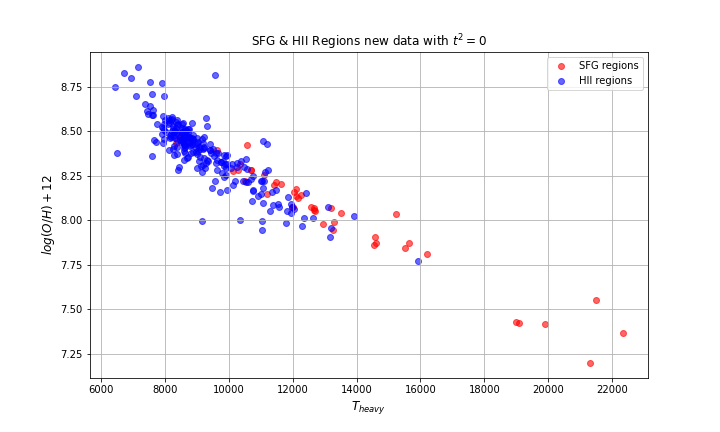

In [32]:
#Vamos a crear mascaras para cada una de las regiones:

#SFG:
mask = ~np.isnan(ionic_SFG_filter['O3_abundance']) & ~np.isnan(total_SFG_filter['O_abundance'])& \
        ~np.isnan(physical_SFG_filter['Te_[OIII]_4363_5007']) &~np.isnan(ionic_SFG_filter['O2_abundance'])\
        &~np.isnan(physical_SFG_filter['Te_[NII]_5755_6584']) &~ np.isnan(physical_SFG_filter['e_Te_[OIII]_4363_5007m'])\
        &~ np.isnan(physical_SFG_filter['e_Te_[OIII]_4363_5007p']) & ~np.isnan(physical_SFG_filter['e_Te_[NII]_5755_6584m'])\
        & ~np.isnan(physical_SFG_filter['e_Te_[NII]_5755_6584p'])

#HII:
mask2 = ~np.isnan(ionic_HII_filter['O3_abundance']) & ~np.isnan(total_HII_filter['O_abundance'])& \
        ~np.isnan(physical_HII_filter['Te_[OIII]_4363_5007']) &~np.isnan(ionic_HII_filter['O2_abundance'])& \
        ~np.isnan(physical_HII_filter['Te_[NII]_5755_6584']) &~ np.isnan(physical_HII_filter['e_Te_[OIII]_4363_5007m'])& \
        ~np.isnan(physical_HII_filter['e_Te_[OIII]_4363_5007p']) & ~np.isnan(physical_HII_filter['e_Te_[NII]_5755_6584m'])& \
        ~np.isnan(physical_HII_filter['e_Te_[NII]_5755_6584p'])

#Esta función determina T_{heavy} a partir de las abudancias totales e ionicas de O y de sus Temperaturas.

#DETERMINA LOS VALORES CENTRALES DE T_{Heavy}
def T_heavy(O3, O2, O, Te_O3, Te_Ne): #Definimos nuestra función de T_pesada
    T = 10**(O3 - O)*Te_O3 + 10**(O2 - O)*Te_Ne
    return T

#Calculamos T_heavy para SFG
T_SFG = T_heavy(ionic_SFG_filter['O3_abundance'][mask],ionic_SFG_filter['O2_abundance'][mask], \
                total_SFG_filter['O_abundance'][mask], physical_SFG_filter['Te_[OIII]_4363_5007'][mask],\
                physical_SFG_filter['Te_[NII]_5755_6584'][mask])

#Calculamos T_heavy para HII
T_HII = T_heavy(ionic_HII_filter['O3_abundance'][mask2],ionic_HII_filter['O2_abundance'][mask2], \
                total_HII_filter['O_abundance'][mask2], physical_HII_filter['Te_[OIII]_4363_5007'][mask2],\
                physical_HII_filter['Te_[NII]_5755_6584'][mask2])

#DATOS DE TEMPERATURA PESADA PARA LAS REGIONES SFG:
print(r'Total de Regiones SFG:', len(T_SFG))

#DATOS DE TEMPERATURA PESADA PARA LAS REGIONES HII
print(r'Total de Regiones HII:', len(T_HII)) 

#Datos totales:
print(r'Total de Regiones a estudiar:' ,len(T_SFG)+ len(T_HII))

### Vamos a visualizar nuestras regiones de forma general para observar su comportamiento:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(T_SFG, total_SFG_filter['O_abundance'][mask], c = 'r', label = 'SFG regions', alpha = 0.6)
ax.scatter(T_HII,total_HII_filter['O_abundance'][mask2], c = 'b', label = 'HII regions', alpha = 0.6)
ax.set_title('SFG & HII Regions new data with $t^2 = 0$')
ax.set_ylabel(r'$log(O/H) + 12$', size = 14)
ax.set_xlabel(r'$T_{heavy}$', size = 14
plt.grid(True)
plt.legend()
plt.savefig('SFG_&_HII_Regions_with_NewData_t2eq0', dpi = 300)

In [4]:
### Contatenar:

#SFG:
Data_SFG = {'Name': total_SFG_filter['File'][mask],'O3_abundance': ionic_SFG_filter['O3_abundance'][mask], 'O2_abundance': ionic_SFG_filter['O2_abundance'][mask],'O_abundance': total_SFG_filter['O_abundance'][mask],'e_O_abundancem': total_SFG_filter['e_O_abundancem'][mask],'e_O_abundancep': total_SFG_filter['e_O_abundancep'][mask], 'Te_[OIII]': physical_SFG_filter['Te_[OIII]_4363_5007'][mask], 'e_Te_[OIII]m':physical_SFG_filter['e_Te_[OIII]_4363_5007m'][mask],'e_Te_[OIII]p':physical_SFG_filter['e_Te_[OIII]_4363_5007p'][mask], 'Te_[NeII]': physical_SFG_filter['Te_[NII]_5755_6584'][mask], 'e_Te_[NeII]m': physical_SFG_filter['e_Te_[NII]_5755_6584m'][mask],'e_Te_[NeII]p': physical_SFG_filter['e_Te_[NII]_5755_6584p'][mask],  'T_heavy': T_SFG}
df_SFG = pd.DataFrame(Data_SFG)

#HII:

Data_HII = {'Name': total_HII_filter['File'][mask2],'O3_abundance': ionic_HII_filter['O3_abundance'][mask2], 'O2_abundance': ionic_HII_filter['O2_abundance'][mask2],'O_abundance': total_HII_filter['O_abundance'][mask2],'e_O_abundancem': total_HII_filter['e_O_abundancem'][mask2],'e_O_abundancep': total_HII_filter['e_O_abundancep'][mask2], 'Te_[OIII]': physical_HII_filter['Te_[OIII]_4363_5007'][mask2], 'e_Te_[OIII]m':physical_HII_filter['e_Te_[OIII]_4363_5007m'][mask2],'e_Te_[OIII]p':physical_HII_filter['e_Te_[OIII]_4363_5007p'][mask2], 'Te_[NeII]': physical_HII_filter['Te_[NII]_5755_6584'][mask2], 'e_Te_[NeII]m': physical_HII_filter['e_Te_[NII]_5755_6584m'][mask2],'e_Te_[NeII]p': physical_HII_filter['e_Te_[NII]_5755_6584p'][mask2],  'T_heavy': T_HII}
df_HII = pd.DataFrame(Data_HII)

print(len(df_SFG) + len(df_HII)) #Vemos si tenemos los mismos datos

#Concatenar:

df_new = pd.concat([df_SFG, df_HII])
df_new = df_new.reset_index()

273


In [5]:
### ESTA FUNCIÓN DETERMINA LOS ERRORES DE T_{Heavy} para cada uno de los datos a partir de un metodo MonteCarlo

def e_T_heavy(O3, O2, O, Te_O3, Te_Ne, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep):
    
    #Número de muestras MonteCarlo
    n_samples = 10000
    
    #Listas vacias:

    e_T_list = [] #Arreglo vacio que almacenará los datos del error minus
    E_T_list = [] #Arreglo vacio que almacenará los datos del error plus

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:
    
    for i in range(len(O3)):         
    
        #Hacemos una simulación MonteCarlo de 100000 muestras para cada Row de nuestro dataframe
        
        T_samples = np.random.standard_normal(n_samples)
    
        T_heavy1 = T_samples*(e_Te_O3m[i]/2 + e_Te_O3p[i]/2)*10**(O3[i] - O[i]) + 10**(O3[i] - O[i])*Te_O3[i]   ##Primer termino de nuestra Ecuación de T_pesada
        T_heavy2 = T_samples*(e_Te_Nem[i]/2 + e_Te_Nep[i]/2)*10**(O2[i] - O[i]) + 10**(O2[i] - O[i])*Te_Ne[i]   ##Primer termino de nuestra Ecuación de T_pesada
    
    
        T_sum = T_heavy1 + T_heavy2   ##Suma de los terminos de nuestra función
    
        T_central = np.median(T_sum)
    
    
    
        e_Thp = round(np.percentile(T_sum, 84) - T_central,2)
        e_Thm = round(T_central - np.percentile(T_sum, 16),2)
        
        #Concatenar:
    
        e_T_list = np.append(e_T_list, np.absolute(e_Thm))
        E_T_list = np.append(E_T_list, np.absolute(e_Thp))
    
    
    return (e_T_list, E_T_list)

#Asignamos nuestros datos a una variable:

O3 = df_new['O3_abundance']
O2 = df_new['O2_abundance']
O = df_new['O_abundance']
Te_O3 = df_new['Te_[OIII]']
Te_Ne = df_new['Te_[NeII]']
e_Te_O3m = df_new['e_Te_[OIII]m']
e_Te_O3p = df_new['e_Te_[OIII]p']
e_Te_Nem = df_new['e_Te_[NeII]m']
e_Te_Nep = df_new['e_Te_[NeII]p']

e_T_total = e_T_heavy(O3, O2, O, Te_O3, Te_Ne, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep)

df_new['e_T'], df_new['E_T'] = e_T_total[0], e_T_total[1]

##Error en y:
yerr = [df_new['e_O_abundancem'], df_new['e_O_abundancep']]

##Error en x:
xerr = [df_new['e_T'], df_new['E_T']]

<IPython.core.display.Javascript object>


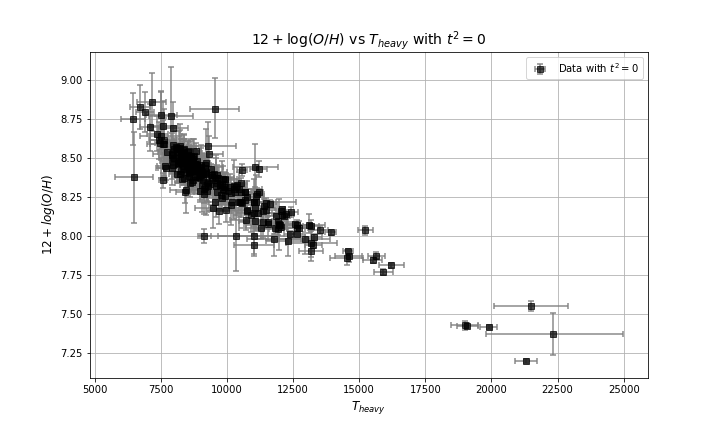

In [40]:
### Vamos a visualizar los datos

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new['T_heavy'], df_new['O_abundance'],xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 = 0$', alpha = 0.7)

ax.set_ylabel('$ 12 + log(O/H)$', size = 12)
ax.set_xlabel('$T_{heavy}$', size = 12)
ax.set_title('$12 + \log(O/H)$ vs $T_{heavy}$ with $t^2 = 0$', size = 14)
plt.grid(True)
plt.legend()
plt.savefig('Scatter_Data_OvsTheavy_with_newdata_t2eq0', dpi = 500)

In [45]:
df_new

,index,Name,O3_abundance,O2_abundance,O_abundance,e_O_abundancem,e_O_abundancep,Te_[OIII],e_Te_[OIII]m,e_Te_[OIII]p,Te_[NeII],e_Te_[NeII]m,e_Te_[NeII]p,T_heavy,e_T,E_T
0,1920,SFG__1159+545__1159+545__Izotov__94__,7.325,6.355,7.370,0.134,0.138,19171.18,470.33,671.43,52262.37,11801.30,31681.75,22332.993410,2541.89,2624.14
1,2080,SFG__HS0837+4717__HS0837+4717__Izotov__04__,7.528,6.296,7.553,0.034,0.033,19368.31,245.24,214.19,58174.95,14675.87,28109.38,21503.975204,1398.84,1388.85
2,2082,SFG__HS0924+3821__HS0924+3821__Izotov__04__,7.966,7.297,8.050,0.051,0.049,12439.46,166.32,215.27,13892.29,1880.81,2972.46,12705.264072,593.69,571.04
3,2086,SFG__HS1213+3636A__HS1213+3636A__Izotov__04__,7.966,7.670,8.146,0.104,0.105,10652.44,274.57,229.38,12419.14,2017.19,1961.03,11188.412303,826.76,829.61
4,2092,SFG__HS1851p6933__HS1851p6933__Izotov__21b__,7.775,7.024,7.847,0.022,0.019,16134.06,367.09,329.49,12199.87,441.41,289.62,15503.031591,350.94,346.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,1231,HII__SMC__NGC456-2__PenaGuerrero__12__,7.892,7.554,8.054,0.043,0.049,12089.50,266.08,151.26,11075.73,841.30,955.03,11827.915292,417.26,432.00
269,1233,HII__SMC__NGC456-a-1__Guseva__11__,7.867,7.667,8.077,0.041,0.043,12167.86,95.71,105.28,11514.88,713.10,717.38,11982.449819,333.31,338.09
270,1236,HII__SMC__NGC456-a-3-m__Guseva__11__,7.904,7.476,8.043,0.038,0.040,11951.43,81.23,96.14,12031.53,1079.28,997.38,11938.779715,343.81,344.99
271,1237,HII__SMC__NGC456-a1__Guseva__11__,7.854,7.638,8.061,0.023,0.022,12176.60,79.81,87.73,11883.36,327.49,461.32,12046.900153,198.85,193.30


## Ajuste Lineal

### Ajuste Lineal ODR y Linregrees:

In [7]:
#Esta funcion es para hacer ajustes lineales considerando barras de error
def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x,y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m, correlation_coefficient


#Hacemos nuestro Ajuste:

#Definimos el eje x:

x = np.linspace(min(df_new['T_heavy']), max(df_new['T_heavy']), len(df_new['T_heavy']))

#Ajuste Lineal ODR:
adjustment = linfit(df_new['T_heavy'], df_new['O_abundance'], df_new['e_T'], df_new['E_T'], df_new['e_O_abundancem'],
                    df_new['e_O_abundancep'])

print('Estos son los parametros del ajuste ODR:', adjustment)

#Ajuste Lineal Linregress:

linre = stats.linregress(df_new['T_heavy'], df_new['O_abundance'])

print('Estos son los parametros del ajuste Linregress:', linre)

Estos son los parametros del ajuste ODR: (9.291653379430434, 0.017685823637256126, -9.611281630392242e-05, 1.6708047156788232e-06, -0.9235373006671012)
Estos son los parametros del ajuste Linregress: LinregressResult(slope=-9.353652716090857e-05, intercept=9.25255668440055, rvalue=-0.9235373006671, pvalue=8.363416109063958e-115, stderr=2.3594852900488524e-06, intercept_stderr=0.02412398121339947)


<IPython.core.display.Javascript object>


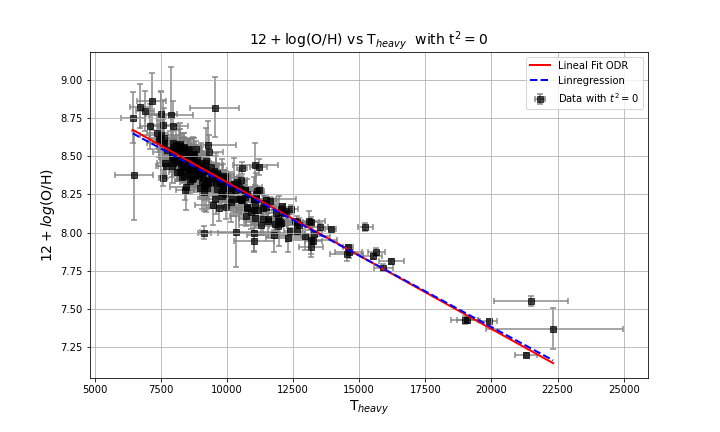

Slope ORD: -0.0000961 ± 0.0000017
Intercept ORD: 9.291653 ± 0.017686
Slope Linregress: -0.000094 ± 0.000002
Intercept Linregress:  9.252557 ± 0.024100


In [53]:
#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new['T_heavy'], df_new['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 = 0$', alpha = 0.7, zorder = 1)

plt.plot(x,  np.dot(np.vander(x, 2), [adjustment[2], adjustment[0]] ) , c = 'r', label = 'Lineal Fit ODR',\
         lw = 2, zorder = 2)

plt.plot(x, np.dot(np.vander(x, 2), [linre[0], linre[1]] ), '--',c = 'b', label = 'Linregression', lw = 2, zorder = 2)


print(f"Slope ORD: {adjustment[2]:.7f} ± {adjustment[3]:.7f}")
print(f"Intercept ORD: {adjustment[0]:.6f} ± {adjustment[1]:.6f}")

print(f'Slope Linregress: {linre[0]: .6f} ± {linre[4]:.6f}')
print(f'Intercept Linregress: {linre[1]: .6f} ± {0.0241:.6f}')

ax.set_title('$12 + \log$(O/H) vs T$_{heavy}$  with t$^2 = 0$', size = 14)
ax.set_ylabel('$12 + log$(O/H)', size = 14)
ax.set_xlabel('T$_{heavy}$', size = 14)
plt.grid(True)
plt.legend(loc = 'upper right', fontsize = 'medium')
plt.savefig('LinealAdjustments_Theavy_vs_O_with_NewData_t2eq0', dpi = 300)

#### Residuos:

<IPython.core.display.Javascript object>


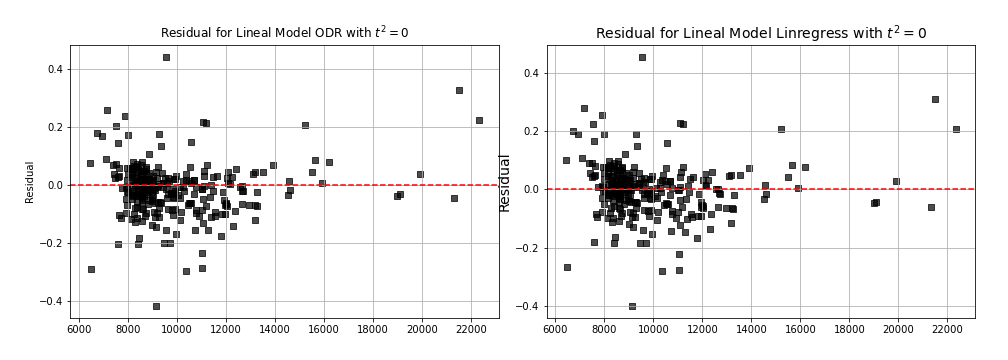

In [52]:
### Haremos el calculo de los residuos y ambos modelos y los vamos a comparar:

y_obs = df_new['O_abundance']

#Residual ODR:

#Definimos la función para determinar los residuos de ODR:

y = adjustment[0] + adjustment[2]*df_new['T_heavy']

Residual_ODR = y_obs - y

#Residual Linregress: 

#Definimos la función para determinar los residuos de Linregress:

y2 = linre[1] + linre[0]*df_new['T_heavy']

Residual_Linregress = y_obs - y2

#Graficamos:

fig, ax = plt.subplots(1,2,figsize= (14,5))



ax[0].scatter(df_new['T_heavy'], Residual_ODR, color='black', marker = 's', alpha=0.7)
ax[0].axhline(0, color='red', linestyle='dashed')
ax[0].set_ylabel("Residual")
ax[0].set_title("Residual for Lineal Model ODR with $t^2 = 0$")
#ax[0].set_ylim(-5000, 5000)
ax[0].grid(True)

fig.tight_layout(pad= 2.5)

ax[1].scatter(df_new['T_heavy'], Residual_Linregress, color='black', marker = 's', alpha=0.7)
ax[1].axhline(0, color='red', linestyle='dashed')
ax[1].set_ylabel("Residual", size = 14)
ax[1].set_title("Residual for Lineal Model Linregress with $t^2 = 0$", size = 14)
#ax[1].set_ylim(-5000, 5000)
ax[1].grid(True)

plt.savefig('Residual_ODR&Linregress_with_NewData_t2eq0', dpi = 300)

## Resultados del modelo:

$$12 + \log_{10}(O/H) = (9.291653 \pm 0.017686) - (0.000096 ± 0.000002)Te $$

Podemos expresar está relación como:

$$ 12 + \log_{10}(O/H) = (9.29 \pm 0.01) - (0.96 \pm 0.02) \dfrac{Te}{10^4K} $$

## Ajuste Cuadratico:

### Ajuste Cuadratico ODR:

(2.7960440817447954e-10, 3.756198829131715e-10, -0.0001029731226267272, 9.394368267520911e-06, 9.331432253504731, 0.056522697186706675, -0.9235373006671012)


<IPython.core.display.Javascript object>


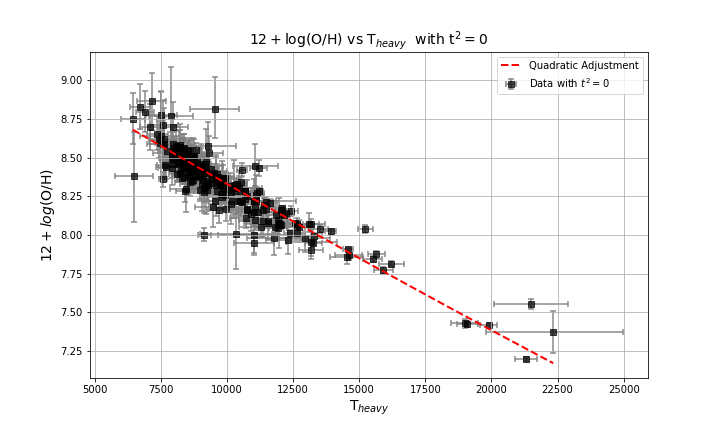

a: 0.000000 ± 0.000000
b: -0.000103 ± 0.000009
c: 9.3314 ± 0.0565
Podemos observar un comportamiento muy lineal, no haremos residuos en este caso, pasaremos a Likelihood


In [51]:
#esta funcion es para hacer ajustes cuadraticos considerando barras de error
def linfit2(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    def quadratic(theta,x):
        a, b, c = theta
        model = a*x**2 + b*x + c
        return model
 
    quad_model = odr.Model(quadratic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    


    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

quadratic = linfit2(df_new['T_heavy'],df_new['O_abundance'], df_new['e_T'],df_new['E_T'],
                    df_new['e_O_abundancem'], df_new['e_O_abundancep']) #Le damos los valores a la función
print(quadratic)


#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new['T_heavy'], df_new['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = 'Data with $t^2 = 0$', alpha = 0.7, zorder = 1)

plt.plot(x, np.dot(np.vander(x, 3), [quadratic[0],quadratic[2], quadratic[4]]),
         '--', c = 'r', lw = 2, label = 'Quadratic Adjustment',  zorder = 2)

print(f"a: {quadratic[0]:.6f} ± {quadratic[1]:.6f}") #Valor de a y su error
print(f"b: {quadratic[2]:.6f} ± {quadratic[3]:.6f}") #Valor de b y su error
print(f"c: {quadratic[4]:.4f} ± {quadratic[5]:.4f}") #Valor de c y sy error

ax.set_ylabel('$12 + log$(O/H)', size = 14)
ax.set_xlabel('T$_{heavy}$', size = 14)
ax.set_title('$ 12 + \log$(O/H) vs T$_{heavy}$  with t$^2 = 0$', size = 14)
plt.grid(True)
plt.legend()
plt.savefig('Quadratic_Adjustment_OvsTheavy_t2eq0', dpi = 500)

print('Podemos observar un comportamiento muy lineal, no haremos residuos en este caso, pasaremos a Likelihood')